In [2]:
import numpy as np
import pylab as pl
import astropy.time
import pandas as pd
from pymsis import msis

import deorblib

from importlib import reload

# Simulating orbital decay

Under the assumption that a satellite of mass $m$ on orbital decay maintains a circular orbit of radius $r$ around the Earth (mass $M$), its velocity $v$ follows the 3rd Kepler law:

$$v^2=\frac{\mu}{r}\;,$$

with $\mu = GM$.

Its kinetic energy $K$ is thus 

$$K = \frac{1}{2}mv^2 = \frac{\mu m}{2r}$$

and its gravitational potential energy $U$ 

$$U=-\frac{\mu m}{r}\;.$$

The mechanical energy $E$ of a satellite in circular orbit is finally

$$E = K + U = -\frac{\mu m}{2r}\;.$$

Dragging and other effects will produce a work $W$ and reduce this mechanical energy via:

$$\frac{\text{d}E}{\text{d}t}=\frac{\text{d}W}{\text{d}t}=P_d(r,t)\;,$$

with $P_d(r,t)$ the power dissipated by various non-conservative forces applied on the satellite.

The variation of mechanical energy being

$$\frac{\text{d}E}{\text{d}t}=\frac{\mu m}{2 r^2}\frac{\text{d}r}{\text{d}t}=P_d(r,t)\;,$$

we can express this variation as a variation of radius (or altitude):

$$\frac{\text{d}r}{\text{d}t} = \frac{2 r^2}{\mu m} P_d(r,t)$$

which gives the differential equation which will be solved below.

From there, any work can be accounted for. As an example, the work of the drag force $D$ over a distance $s$ is $W_D = -Ds$ and the power dissipated is thus 

$$P_D = -Dv\;,$$

Note that the drag force can be calculated with the relation

$$D=\frac{1}{2}C_{\text{drag}} A_{\text{drag}} \rho(r) v^2\;.$$

## Bibliography

* Chaparro et al. 2023 (https://academicworks.cuny.edu/cgi/viewcontent.cgi?article=2051&context=ny_pubs)

Ballistic coeff:  100.0
re-entry achieved
elpased time:  112.61574074074075 d
number of orbits:  1787.6201253490394
work done on satellite: -1.71e+09 J
mean drag power: -1.76e+02 W


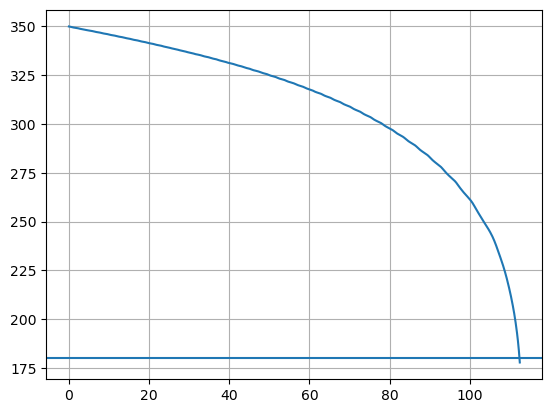

In [55]:
reload(deorblib)

# satellite
mass = 2200 # kg
drag_area = 10 #m²
drag_coeff = 2.2
B = mass / (drag_coeff * drag_area) # ballistic coeff
print('Ballistic coeff: ', B)

TAIModJd = 21545
h = 350e3 #m
dt = 10000 #s
f107 = 150
Ap = 3
lat = 0

dissipative_power = 0 # W


def drag(r, lon, date, dt):
    h = r - deorblib.R_earth
    v = deorblib.kepler_velocity(h)
    dens = msis.run(date + np.timedelta64(dt, 's'), np.fmod(lon + np.rad2deg(v/r * dt), 360) - 180, 
                    lat, h/1000, f107, f107, [[Ap] * 7], version=0)[0,0]
    return 0.5 * drag_coeff * drag_area * dens * v**2

def dr_dt(r, lon, date, dt):
    D = drag(r, lon, date, dt)
    v = deorblib.kepler_velocity(h)
    P_D = D * v
    dr = - 2 / (deorblib.mu_earth * mass) * r**2 * (P_D + dissipative_power)
    return dr


def E_orbit(r):
    """Mechanical energy in orbit"""
    return - 0.5 * deorblib.mu_earth * mass / r
    

i = 0
r = h + deorblib.R_earth
allr = list()
lon = 0
W = 0
date = deorblib.taimodjd2date(TAIModJd)

while True:
    # compute orbital energy
    E = E_orbit(r)
    
    # improved Euler method
    # https://math.libretexts.org/Courses/Monroe_Community_College/MTH_225_Differential_Equations/03%3A_Numerical_Methods/3.02%3A_The_Improved_Euler_Method_and_Related_Methods

    k1 = dr_dt(r, lon, date, 0)
    k2 = dr_dt(r + dt*k1, lon, date, dt)
    r += (k1 + k2) * dt/2

    # compute work
    W += E_orbit(r) - E
    
    # update longitude
    h = r - deorblib.R_earth
    v = deorblib.kepler_velocity(h)
    lon += np.rad2deg(v/r * dt)

    i += 1
    date += np.timedelta64(dt, 's')
    allr.append(r)

    if i > 100000: 
        print('too many iteration')
        break
    if r < 180e3 + deorblib.R_earth:
        print('re-entry achieved')
        break

    
print('elpased time: ', i * dt/3600/24 , 'd')
print('number of orbits: ', lon / 360)
print('work done on satellite: {:.2e} J'.format(W))
print('mean drag power: {:.2e} W'.format(W/(i * dt)))
allr = np.array(allr)
pl.plot(np.arange(i)*dt/3600/24, (allr - deorblib.R_earth)/1000)
pl.axhline(180)
pl.grid()